In [3]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from patsy import dmatrix  # for generation of (regression) design matrices
from pandas import Series  # to manipulate data-frames generated by hddm
from joblib import Parallel, delayed
from IPython import embed as shell

C:\Users\aleya\miniconda3\envs\py36\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [75]:
#### Import data ####

import csv

df = pd.read_csv('gng_model_data.csv')

#based on correspondence with Jan Willem, the response and stim columns need to have 1s and 0s to match. If both have the same number = correct, if not = wrong
df.stim[(df.stim == 1)] = 1
df.stim[(df.stim == 2)] = 0

print(df)

n_subjects = df['participant'].nunique()

#print(n_subjects)

        participant        rt  response  subj_idx  stim  correct
0                 2       NaN         0         0     1        0
1                 2       NaN         0         0     0        1
2                 2  0.417053         1         0     1        1
3                 2       NaN         0         0     0        1
4                 2  0.313026         1         0     1        1
...             ...       ...       ...       ...   ...      ...
191882         9028  0.318772         1       385     1        1
191883         9028  0.426638         1       385     1        1
191884         9028  0.364879         1       385     0        0
191885         9028       NaN         0       385     1        0
191886         9028       NaN         0       385     0        1

[191887 rows x 6 columns]
386


C:\Users\aleya\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\aleya\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [30]:
# define model functions based on tutorial here: https://hddm.readthedocs.io/en/latest/tutorial_gonogo_chisquare.html

#### Some terminology defined ####
# drift criterion = estimates bias in drift rate (v), set to True to allow v.go and v.nogo to have separate values
# bias estimates = bias in starting point (z), if set to False, z would be 0.5. Z won't be estimated unless bias is set to True 
# split param: to assign positive drift rate to Go and negative drift rates to no-go stimuli
# depends on = estimate different parameter values for each condition/stimulus


# Model 1: two Vs (dc) and z allowed to vary
def fit_subject1(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, include=['v', 'a', 't', 'z'], stim_col='stim', 
                            split_param='v', drift_criterion=True, bias=True, p_outlier=0.05)
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res


# Model 2: Two Vs and z = 0.5

def fit_subject2(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, include=['v', 'a', 't'], stim_col='stim', 
                            split_param='v', drift_criterion=True, bias=False, p_outlier=0.05)
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

# Model 3: single V and z allowed to vary
def fit_subject3(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, include=['v', 'a', 't', 'z'], stim_col='stim', 
                            split_param='v', drift_criterion=False, bias=True, p_outlier=0.05)
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

# Model 4: single v and z = 0.5

def fit_subject4(data, quantiles):

    """
    Simulates stim-coded data.
    """

    subj_idx = np.unique(data['subj_idx'])
    m = hddm.HDDMStimCoding(data, include=['v', 'a', 't'], stim_col='stim', 
                            split_param='v', drift_criterion=False, bias=False, p_outlier=0.05)
    m.optimize('gsquare', quantiles=quantiles, n_runs=8)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res


In [6]:
# Define array for storing BIC values (Bayesian Information Criterion: for assessing model fit. The lower the BIC the better the fit)

model_bic = [0,0,0,0,0]

# define quantiles
quantiles = [.1, .3, .5, .7, .9]

In [9]:
# Model 1: two Vs (dc) and z allowed to vary

params_fitted1 = pd.concat(Parallel(n_jobs=30)(delayed(fit_subject1)(data[1], quantiles)
                                                      for data in df.groupby('subj_idx')))

#add subject ID to column
params_fitted1['subject_id'] = df['participant'].unique()

print(params_fitted1.head())

params_fitted1.to_csv('Model1.csv')

model_bic[0] = params_fitted1["bic"].mean()

print(model_bic) # parameter values per subject printed below

          a          v         t   z_trans         z        dc   likelihood  \
0  1.098223   2.783825  0.200154 -0.309528  0.423230  1.336615 -1780.100768   
1  0.687549   1.463849  0.246508 -0.344879  0.414625  1.424759 -1852.721830   
2  0.611926   2.253813  0.270889 -0.738510  0.323330  1.708756 -1803.899203   
3  0.689506   2.697233  0.279232 -0.458720  0.387290  1.026662 -1743.316322   
4  1.273488  12.930848  0.262431 -1.759613  0.146839 -3.899028 -1526.841089   

     penalty          bic  subject_id  
0  37.287649  1817.388417           2  
1  37.263600  1889.985431           7  
2  37.263600  1841.162803          18  
3  37.263600  1780.579923          21  
4  37.287649  1564.128738          27  
[1508.168070104993, 0, 0, 0, 0]


In [7]:
# Model 2: Two Vs and z = 0.5

params_fitted2 = pd.concat(Parallel(n_jobs=30)(delayed(fit_subject2)(data[1], quantiles)
                                                      for data in df.groupby('subj_idx')))
params_fitted2['subject_id'] = df['participant'].unique()

print(params_fitted2.head())
params_fitted2.to_csv('Model2.csv')

model_bic[1] = params_fitted2["bic"].mean()

print(model_bic)

          a         v         t        dc   likelihood    penalty          bic
0  1.284826  2.854974  0.198648  1.310954 -1784.164688  24.858432  1809.023121
1  0.684917  1.497026  0.252354  0.828892 -1855.885805  24.842400  1880.728205
2  0.577706  2.215725  0.281388  0.238879 -1814.594093  24.842400  1839.436493
3  0.672229  2.727010  0.286829  0.173763 -1749.469456  24.842400  1774.311856
4  2.396450  6.125646  0.254252  3.280946 -1539.133229  24.858432  1563.991661
[1766.9756138579262, 1769.7052323663493, 0, 0]


In [8]:
# Model 3: single V and z allowed to vary

params_fitted3 = pd.concat(Parallel(n_jobs=30)(delayed(fit_subject3)(data[1], quantiles)
                                                      for data in df.groupby('subj_idx')))

params_fitted3['subject_id'] = df['participant'].unique()
print(params_fitted3.head())
params_fitted3.to_csv('Model3.csv')

model_bic[2] = params_fitted3["bic"].mean()

print(model_bic)

          a          v         t   z_trans         z   likelihood   penalty  \
0  1.022497   3.228474  0.215771  0.128649  0.532118 -1805.549718  31.07304   
1  0.663681   1.787701  0.262841  0.295622  0.573372 -1864.674642  31.05300   
2  0.572010   2.495651  0.280435 -0.097355  0.475680 -1814.679544  31.05300   
3  0.663590   2.969781  0.285823 -0.103815  0.474070 -1749.033086  31.05300   
4  1.781659  10.477535  0.227175 -2.306141  0.090616 -1525.292978  31.07304   

           bic  
0  1836.622759  
1  1895.727642  
2  1845.732545  
3  1780.086086  
4  1556.366018  
[1766.9756138579262, 1769.7052323663493, 1782.5853844957874, 0]


In [9]:
# Model 4: single v and z = 0.5

params_fitted4 = pd.concat(Parallel(n_jobs=30)(delayed(fit_subject4)(data[1], quantiles)
                                                      for data in df.groupby('subj_idx')))
params_fitted4['subject_id'] = df['participant'].unique()
print(params_fitted4.head())
params_fitted4.to_csv('Model4.csv')

model_bic[3] = params_fitted4["bic"].mean()

print(model_bic)

          a          v         t   likelihood    penalty          bic
0  0.997650   3.311226  0.213669 -1806.366225  18.643824  1825.010049
1  0.660758   2.044128  0.255389 -1872.173825  18.631800  1890.805625
2  0.574435   2.370613  0.281534 -1815.515934  18.631800  1834.147734
3  0.667726   2.844839  0.287068 -1749.931446  18.631800  1768.563246
4  3.241009  10.538153  0.227217 -1538.010408  18.643824  1556.654232
[1766.9756138579262, 1769.7052323663493, 1782.5853844957874, 1791.065416431145]


In [6]:
# Get mean values of winning model

params_fitted1.mean()# use these values for simulating data in cell below

a                0.997052
v                2.290907
t                0.239753
z_trans         -1.048193
z                0.316771
dc               2.418257
likelihood   -1730.656371
penalty         37.249339
bic           1767.905711
subject_id     972.562176
dtype: float64

In [4]:
# if model is saved to .csv already
params_fitted1 = pd.read_csv('Model1.csv')
print(params_fitted1)

params_fitted1.mean()# use these values for simulating data in cell below

     Unnamed: 0         a          v         t   z_trans         z         dc  \
0             0  1.121627   2.769482  0.194137 -0.465339  0.385720   1.543662   
1             1  0.687549   1.463849  0.246508 -0.344879  0.414625   1.424759   
2             2  0.612065   2.250572  0.270840 -0.733415  0.324446   1.703158   
3             3  0.693634   2.725317  0.278438 -0.496564  0.378348   1.080125   
4             4  1.732372  21.363466  0.230340 -2.278131  0.092950 -10.999991   
..          ...       ...        ...       ...       ...       ...        ...   
381         381  0.740229   3.582887  0.283591 -0.642649  0.344648   1.403774   
382         382  0.787777   2.774826  0.271607 -1.044546  0.260274   1.846710   
383         383  0.691543   1.409387  0.246750 -0.747304  0.321409   1.580420   
384         384  0.733371   3.455745  0.296714 -0.429058  0.394351   1.438131   
385         385  0.691697   1.709691  0.257367 -0.451935  0.388901   1.451833   

      likelihood    penalty

Unnamed: 0     192.500000
a                0.995915
v               -0.968514
t                0.239026
z_trans         -1.110301
z                0.308933
dc               3.720659
likelihood   -1729.726275
penalty         37.249339
bic           1766.975614
dtype: float64

In [58]:
#### Define Functions for Simulation based on tutorial here: https://hddm.readthedocs.io/en/latest/tutorial_gonogo_chisquare.html ####

def get_choice(row):

    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0
        
def simulate_data(a, v, t, z, dc, sv=0, sz=0, st=0, condition=0, nr_trials1=500, nr_trials2=500):

    """
    Simulates stim-coded data.
    """

    parameters1 = {'a':a, 'v':v+dc, 't':t, 'z':z, 'sv':sv, 'sz': sz, 'st': st}
    parameters2 = {'a':a, 'v':v-dc, 't':t, 'z':1-z, 'sv':sv, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stim'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])

    return df_sim

In [124]:
model_win = params_fitted1
go_nogo = True 
n_subjects = 500
trials_per_level = 250

    # parameters:
params0 = {'cond':0, 'v':model_win["v"].mean(), 'a':model_win["a"].mean(), 't':model_win["t"].mean(), 
           'z':model_win["z"].mean(), 'dc':-(model_win["dc"].mean()), 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':0, 'v':model_win["v"].mean(), 'a':model_win["a"].mean(), 't':model_win["t"].mean(), 
           'z':model_win["z"].mean(), 'dc':model_win["dc"].mean(), 'sz':0, 'st':0, 'sv':0}


# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'],
                        t=params0['t'], sv=params0['sv'], st=params0['st'], sz=params0['sz'],
                        condition=params0['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'],
                        t=params1['t'], sv=params1['sv'], st=params1['st'], sz=params1['sz'],
                        condition=params1['cond'], nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)
    
    # combine in one dataframe:
df_emp = pd.concat(dfs)
if go_nogo:
    df_emp.loc[df_emp["response"]==0, 'rt'] = np.NaN
    


In [125]:
# remove condition 0
df_emp = df_emp[df_emp['condition'] == 1]
print(df_emp)

    # save simulated data    
df_emp.to_csv('data_sim.csv')

           rt  response  subj_idx  condition  correct  stim
0         NaN         0         0          0        0     1
1         NaN         0         0          0        0     1
2         NaN         0         0          0        0     1
3         NaN         0         0          0        0     1
4         NaN         0         0          0        0     1
..        ...       ...       ...        ...      ...   ...
495  0.331026         1       499          0        0     0
496  0.354026         1       499          0        0     0
497  0.363026         1       499          0        0     0
498       NaN         0       499          0        1     0
499  0.770026         1       499          0        0     0

[750000 rows x 6 columns]


In [88]:
# try model 1 on simulated data
quantiles =  [.1, .3, .5, .7, .9]
params_sim1 = pd.concat(Parallel(n_jobs=30)(delayed(fit_subject1)(data[1], quantiles)
                                                      for data in df_emp.groupby('subj_idx')))

params_sim1.to_csv('SimModel1.csv')
print(params_sim1.head())

          a         v         t   z_trans         z        dc   likelihood  \
0  1.067935 -0.971254  0.230527 -1.072647  0.254900  4.613776 -1900.753716   
1  0.955145 -1.072658  0.253810 -0.559710  0.363615  3.803160 -1893.181353   
2  0.961543 -0.918349  0.243004 -0.787178  0.312775  3.650016 -1903.939419   
3  1.183093 -1.052031  0.214709 -1.314164  0.211791  4.877973 -1907.507938   
4  1.174908 -0.744479  0.217862 -1.325726  0.209867  4.850117 -1907.003119   

     penalty          bic  
0  37.287649  1938.041364  
1  37.287649  1930.469002  
2  37.287649  1941.227068  
3  37.287649  1944.795587  
4  37.287649  1944.290767  


In [89]:
# Get mean values of winning model

params_sim1.mean() 

a                1.030152
v               -1.036543
t                0.238610
z_trans         -0.826940
z                0.307543
dc               4.078474
likelihood   -1891.222829
penalty         37.287649
bic           1928.510477
dtype: float64

In [76]:
##### Calculate % Go (stim1) and No-Go (stim 2) errors for real data #####

# get number of correct per subject
persub_correct=df.groupby(['participant','stim'], as_index = False)['correct'].sum()

#get number of trials per subject
num_valid_trials=df.groupby(['participant','stim'], as_index = False)['subj_idx'].count()

# rename subj_idx to trials_num
num_valid_trials.rename(columns = {'subj_idx':'trials_num'}, inplace = True)

print(persub_correct.head())

print(num_valid_trials.head())

# merge 2 dataframes above

new_df = pd.merge(persub_correct, num_valid_trials, on = ['participant', 'stim'])

# calculate % go and % no go errors per participant

new_df["perc_error"] = ((new_df["trials_num"] - new_df["correct"])/new_df["trials_num"])*100

print(new_df.head())


   participant  stim  correct
0            2     0       82
1            2     1      387
2            7     0       59
3            7     1      327
4           18     0       71
   participant  stim  trials_num
0            2     0         100
1            2     1         400
2            7     0         100
3            7     1         398
4           18     0          99
   participant  stim  correct  trials_num  perc_error
0            2     0       82         100   18.000000
1            2     1      387         400    3.250000
2            7     0       59         100   41.000000
3            7     1      327         398   17.839196
4           18     0       71          99   28.282828


In [77]:
# get mean errors across participants
mean_real = new_df.groupby(['stim'], as_index = False)['perc_error'].mean()
print(mean_real)
std_real = new_df.groupby(['stim'], as_index = False)['perc_error'].sem()
print(std_real)

   stim  perc_error
0     0   30.496563
1     1   20.741043
   stim  perc_error
0     0    0.850185
1     1    0.845768


In [78]:
print(df_emp)

           rt  response  subj_idx  condition  correct  stim
0         NaN         0         0          1        0     1
1    0.427026         1         0          1        1     1
2    0.338026         1         0          1        1     1
3    0.608026         1         0          1        1     1
4    0.409026         1         0          1        1     1
..        ...       ...       ...        ...      ...   ...
245  0.378026         1       499          1        0     0
246  0.316026         1       499          1        0     0
247  0.396026         1       499          1        0     0
248  0.551026         1       499          1        0     0
249  0.341026         1       499          1        0     0

[250000 rows x 6 columns]


In [79]:
##### Calculate % Go (stim1) and No-Go (stim 2) errors for sim data #####

#rt response subj_idx condition correct
##### Simulated Data #####

# get number of correct per subject
df_sim=df_emp.groupby(['subj_idx','stim'], as_index = False)['correct'].sum()

# calculate % go and % no go errors per participant

df_sim["perc_error"] = ((trials_per_level - df_sim["correct"])/trials_per_level)*100

print(df_sim)

     subj_idx  stim  correct  perc_error
0           0     0       15        94.0
1           0     1      209        16.4
2           1     0       15        94.0
3           1     1      210        16.0
4           2     0       18        92.8
..        ...   ...      ...         ...
995       497     1      208        16.8
996       498     0       21        91.6
997       498     1      209        16.4
998       499     0       15        94.0
999       499     1      214        14.4

[1000 rows x 4 columns]


In [80]:
mean_sim = df_sim.groupby(['stim'], as_index = False)['perc_error'].mean()
print(mean_sim)
std_sim = df_sim.groupby(['stim'], as_index = False)['perc_error'].sem()
print(std_sim)

   stim  perc_error
0     0     94.5112
1     1     18.0704
   stim  perc_error
0     0    0.065706
1     1    0.105847


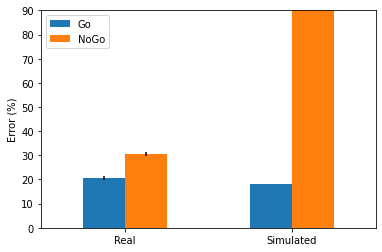

In [81]:
#### Plot real vs simulated data for Go and No-Go errors ####

import matplotlib.pyplot as plt

# create dataframe

Go = [mean_real.iloc[1,1], mean_sim.iloc[1,1]]
NoGo = [mean_real.iloc[0,1], mean_sim.iloc[0,1]]
index = ['Real', 'Simulated']
df_plot = pd.DataFrame({'Go': Go, 'NoGo': NoGo}, index=index)

# dicts with errors
Go_error = {mean_real.iloc[0,1]: {'min': mean_real.iloc[0,1] - std_real.iloc[0,1],'max': mean_real.iloc[0,1] + std_real.iloc[0,1]},
               mean_sim.iloc[0,1]: {'min': mean_sim.iloc[0,1] - std_sim.iloc[0,1],'max': mean_sim.iloc[0,1] + std_sim.iloc[0,1]}}
NoGo_error =  {mean_real.iloc[1,1]: {'min': mean_real.iloc[1,1] - std_real.iloc[1,1],'max': mean_real.iloc[1,1] + std_real.iloc[1,1]},
               mean_sim.iloc[1,1]: {'min': mean_sim.iloc[1,1] - std_sim.iloc[1,1],'max': mean_sim.iloc[1,1] + std_sim.iloc[1,1]}}

# combine them; providing all the keys are unique
z = {**Go_error, **NoGo_error}

# plot
ax = df_plot.plot.bar(rot=0)
plt.ylabel('Error (%)')
plt.ylim(0, 90)

for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = z[h]['min']  # use h to get min from dict z
    max_y = z[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

In [82]:
##### Calculate % Go (stim1) and No-Go (stim 2) RT for real data #####

# get number of correct per subject
persub_correct=df.groupby(['participant','stim'], as_index = False)['rt'].mean()

#get number of trials per subject
num_valid_trials=df.groupby(['participant','stim'], as_index = False)['subj_idx'].count()

# rename subj_idx to trials_num
num_valid_trials.rename(columns = {'subj_idx':'trials_num'}, inplace = True)

print(persub_correct.head())

print(num_valid_trials.head())

# merge 2 dataframes above

new_df = pd.merge(persub_correct, num_valid_trials, on = ['participant', 'stim'])

# calculate % go and % no go errors per participant

print(new_df.head())

   participant  stim        rt
0            2     0  0.276117
1            2     1  0.346500
2            7     0  0.310491
3            7     1  0.349081
4           18     0  0.322619
   participant  stim  trials_num
0            2     0         100
1            2     1         400
2            7     0         100
3            7     1         398
4           18     0          99
   participant  stim        rt  trials_num
0            2     0  0.276117         100
1            2     1  0.346500         400
2            7     0  0.310491         100
3            7     1  0.349081         398
4           18     0  0.322619          99


In [83]:
# get mean RT across participants
mean_real = new_df.groupby(['stim'], as_index = False)['rt'].mean()
print(mean_real)
std_real = new_df.groupby(['stim'], as_index = False)['rt'].sem()
print(std_real)

   stim        rt
0     0  0.328012
1     1  0.359416
   stim        rt
0     0  0.001479
1     1  0.001419


In [84]:
##### Calculate % Go (stim1) and No-Go (stim 2) RT for sim data #####

##### Simulated Data #####

# get number of correct per subject
df_sim=df_emp.groupby(['subj_idx','stim'], as_index = False)['rt'].mean()

# calculate % go and % no go errors per participant

#df_sim["perc_error"] = ((trials_per_level - df_sim["correct"])/trials_per_level)*100

print(df_sim)

     subj_idx  stim        rt
0           0     0  0.372856
1           0     1  0.433175
2           1     0  0.375869
3           1     1  0.445888
4           2     0  0.382199
..        ...   ...       ...
995       497     1  0.433598
996       498     0  0.381393
997       498     1  0.435710
998       499     0  0.377030
999       499     1  0.443928

[1000 rows x 3 columns]


In [85]:
mean_sim = df_sim.groupby(['stim'], as_index = False)['rt'].mean()
print(mean_sim)
std_sim = df_sim.groupby(['stim'], as_index = False)['rt'].sem()
print(std_sim)

   stim        rt
0     0  0.377838
1     1  0.441658
   stim        rt
0     0  0.000208
1     1  0.000388


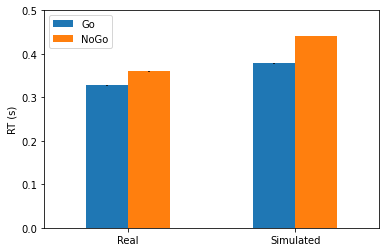

In [86]:
#### Plot real vs simulated data for Go and No-Go RT ####

import matplotlib.pyplot as plt

# create dataframe

Go = [mean_real.iloc[0,1], mean_sim.iloc[0,1]]
NoGo = [mean_real.iloc[1,1], mean_sim.iloc[1,1]]
index = ['Real', 'Simulated']
df = pd.DataFrame({'Go': Go, 'NoGo': NoGo}, index=index)

# dicts with errors
Go_error = {mean_real.iloc[0,1]: {'min': mean_real.iloc[0,1] - std_real.iloc[0,1],'max': mean_real.iloc[0,1] + std_real.iloc[0,1]},
               mean_sim.iloc[0,1]: {'min': mean_sim.iloc[0,1] - std_sim.iloc[0,1],'max': mean_sim.iloc[0,1] + std_sim.iloc[0,1]}}
NoGo_error =  {mean_real.iloc[1,1]: {'min': mean_real.iloc[1,1] - std_real.iloc[1,1],'max': mean_real.iloc[1,1] + std_real.iloc[1,1]},
               mean_sim.iloc[1,1]: {'min': mean_sim.iloc[1,1] - std_sim.iloc[1,1],'max': mean_sim.iloc[1,1] + std_sim.iloc[1,1]}}

# combine them; providing all the keys are unique
z = {**Go_error, **NoGo_error}

# plot
ax = df.plot.bar(rot=0)
plt.ylabel('RT (s)')
plt.ylim(0, 0.5)

for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = z[h]['min']  # use h to get min from dict z
    max_y = z[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

In [90]:
print(params_sim1.head())

          a         v         t   z_trans         z        dc   likelihood  \
0  1.067935 -0.971254  0.230527 -1.072647  0.254900  4.613776 -1900.753716   
1  0.955145 -1.072658  0.253810 -0.559710  0.363615  3.803160 -1893.181353   
2  0.961543 -0.918349  0.243004 -0.787178  0.312775  3.650016 -1903.939419   
3  1.183093 -1.052031  0.214709 -1.314164  0.211791  4.877973 -1907.507938   
4  1.174908 -0.744479  0.217862 -1.325726  0.209867  4.850117 -1907.003119   

     penalty          bic  
0  37.287649  1938.041364  
1  37.287649  1930.469002  
2  37.287649  1941.227068  
3  37.287649  1944.795587  
4  37.287649  1944.290767  


In [91]:
params_sim1.drop(['bic', 'likelihood', 'penalty', 'z_trans'], axis=1, inplace=True)
print(params_sim1.head())

          a         v         t         z        dc
0  1.067935 -0.971254  0.230527  0.254900  4.613776
1  0.955145 -1.072658  0.253810  0.363615  3.803160
2  0.961543 -0.918349  0.243004  0.312775  3.650016
3  1.183093 -1.052031  0.214709  0.211791  4.877973
4  1.174908 -0.744479  0.217862  0.209867  4.850117


In [95]:
params_fitted1.mean()# use these values for plotting data in cell below

Unnamed: 0     192.500000
a                0.995915
v               -0.968514
t                0.239026
z_trans         -1.110301
z                0.308933
dc               3.720659
likelihood   -1729.726275
penalty         37.249339
bic           1766.975614
dtype: float64

In [96]:
print(params1)

{'cond': 1, 'v': -0.9685144250984451, 'a': 0.9959146958290156, 't': 0.2390262027943264, 'z': 0.3089333005803109, 'dc': 3.720658898124352, 'sz': 0, 'st': 0, 'sv': 0}


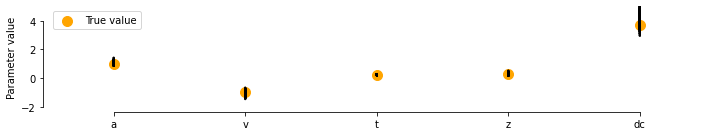

In [121]:
# Plot true vs recovered parameters: for model 1
x = np.arange(5) 
y0 = np.array([params1['a'], params1['v'], params1['t'],params1['z'], params1['dc']])
fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, marker="o", s=100, color='orange', label='True value')
#ax.scatter(x+1, y1, marker="o", s=100, color='orange',)
sns.stripplot(data=params_sim1, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['black', 'black'], ax=ax)
plt.ylabel('Parameter value')
plt.ylim(-2, 5)
plt.legend()
sns.despine(offset=5, trim=True,)
plt.tight_layout()
plt.show()

#save as jpg
fig.savefig('Param_recovery.jpg',bbox_inches='tight')